# Varational Autoencoder

##### Adapted from https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from IPython.display import display

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.models import load_model

%matplotlib inline

<img src="images/VAE_Annotated.png" title="Title text" />

### Set VAE parameters

In [50]:
original_dim = 784
intermediate_dim = 256
latent_dim = 2

batch_size = 100
epochs = 25

epsilon_std = 0.1

### Components of the autoencoder model

In [51]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

### Define a function to sample from a normal distribution

In [52]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### Define the intermediate layers

In [53]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### Define the K-L divergence

In [54]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

### Read and process the MNIST digit data

In [55]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Show some examples of the genuine digits

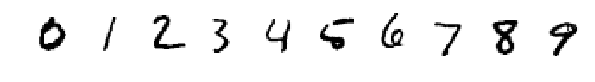

In [89]:
#Show the offending numbers with their labels
n_display = 10
plt.figure(figsize=(10, 4))

for n,i in enumerate([3,2,1,112,4,8,123,0,128,9]):
    #Original images
    ax = plt.subplot(1,n_display,n+1)
    
    plt.imshow((1-x_test[i]).reshape(28, 28),cmap='Greys_r')    
    
    ax.axis('off')

plt.show()

### Fit the VAE model

In [61]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
 - 16s - loss: 147.7670 - val_loss: 148.9073
Epoch 2/25
 - 18s - loss: 147.5822 - val_loss: 149.0358
Epoch 3/25
 - 16s - loss: 147.4434 - val_loss: 149.1065
Epoch 4/25
 - 15s - loss: 147.2744 - val_loss: 149.0840
Epoch 5/25
 - 13s - loss: 147.1157 - val_loss: 149.2673
Epoch 6/25
 - 17s - loss: 146.9898 - val_loss: 148.5486
Epoch 7/25
 - 18s - loss: 146.8491 - val_loss: 148.3537
Epoch 8/25
 - 15s - loss: 146.7285 - val_loss: 148.3313
Epoch 9/25
 - 17s - loss: 146.6085 - val_loss: 148.1831
Epoch 10/25
 - 13s - loss: 146.4613 - val_loss: 148.5383
Epoch 11/25
 - 15s - loss: 146.3594 - val_loss: 148.3331
Epoch 12/25
 - 14s - loss: 146.2278 - val_loss: 148.0191
Epoch 13/25
 - 16s - loss: 146.1362 - val_loss: 147.6970
Epoch 14/25
 - 18s - loss: 146.0488 - val_loss: 147.9527
Epoch 15/25
 - 14s - loss: 145.9086 - val_loss: 148.5393
Epoch 16/25
 - 17s - loss: 145.8031 - val_loss: 147.8977
Epoch 17/25
 - 13s - loss: 145.6653 - val_loss:

### Define the model to project inputs into latent space

In [63]:
encoder = Model(x, z_mean)

### 2D plot of the digit classes in the latent space

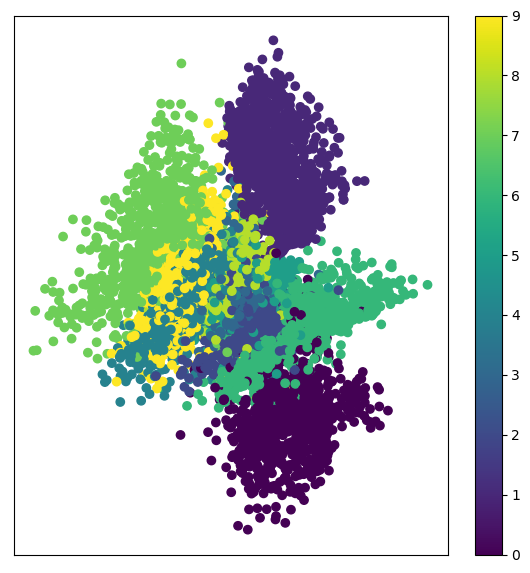

In [98]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(7, 7))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.xticks([],[])
plt.yticks([],[])
plt.colorbar()
plt.show()

### Generator model that can sample from the learned distribution

In [65]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### What do synthetic digits look like when sampling around latent space?

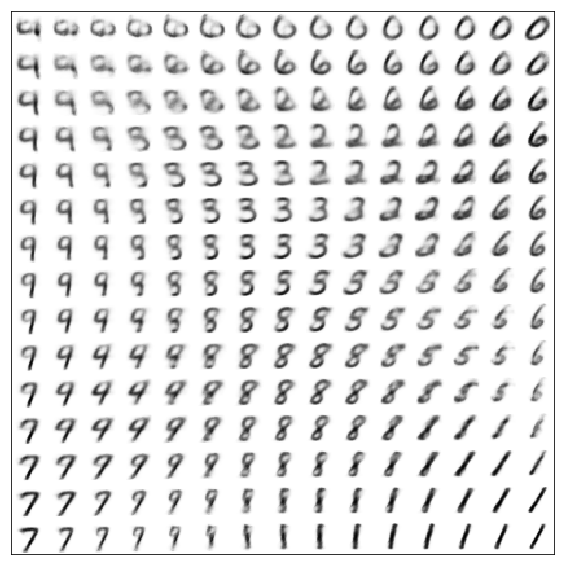

In [76]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = 1-x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.xticks([], [])
plt.yticks([], [])

plt.show()